In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
# prod_in = pd.read_csv('C:\\Users\\jsingh\\Documents\\local_projects\\PC_projects\\QBI\\qcast\\results\\TC_examples_buildup\\Gas_Example_bounds_qi_forecast_2wells.csv', index_col=0)
# prod_in = pd.read_csv('C:\\Users\\jsingh\\Documents\\local_projects\\PC_projects\\QBI\\qcast\\results\\TC_examples_buildup\\Gas_Example_bounds_qi_forecast.csv', index_col=0)
prod_in = pd.read_csv('./Gas_Example_bounds_qi_forecast.csv', index_col=0)

In [3]:
prod_in.head(3)

,date,index,days_on,oil_actual_daily,oil_actual_monthly,oil_pred_daily,gas_actual_daily,gas_actual_monthly,gas_pred_daily,water_actual_daily,...,boe20_pred_cumulative,oil_combined_monthly,gas_combined_monthly,water_combined_monthly,ngl_combined_monthly,boe6_combined_monthly,boe20_combined_monthly,batch_name,unique_id,timestamp
api,,,,,,,,,,,,,,,,,,,,,
3504925141,2018-02-01,1,28,18.571429,520.0,18.571429,0.000000,0.0,NaN,0.0,...,520.000000,520.0,0.0,0,0,520.000000,520.00,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
3504925141,2018-03-01,2,31,343.935484,10662.0,343.935484,443.580645,13751.0,443.580645,0.0,...,11869.550000,10662.0,13751.0,0,0,12953.833333,11349.55,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59
3504925141,2018-04-01,3,30,434.533333,13036.0,359.492601,2124.600000,63738.0,1965.801708,0.0,...,25603.030604,13036.0,63738.0,0,0,23659.000000,16222.90,BATCH RUN,BATCH_RUN_jsingh_2023-10-09-T172159CDT,2023-10-09 17:21:59


In [4]:
prod_avg = prod_in.groupby('index')[['oil_combined_monthly', 'gas_combined_monthly']].mean().reset_index()

In [5]:
def hyperbolic_equation(t, qi, b, di):
    """
    Hyperbolic decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
    Output:
        Returns q, or the expected production rate at time t. Float.
    """
    eps =10e-8
    if b<eps:
        b=eps
    if qi<eps:
        qi=eps
    if di<eps:
        di = eps
    if di>1-eps:
        di = 1-eps
    if b>2:
        b=2
    q = qi/((1.0+b*di*t)**(1.0/b))
    N = q.cumsum()
    return q

def exponential(t,q0,alpha):
    """
    Exponential decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units
        (days, months, etc) so long as they are consistent.
        q0: Float. Initial production rate when well first came online.
        alpha: Float. Exponential decline constant
    Output:
        Returns q, or the expected production rate at time t. Float.
    """
    eps =10e-8
    if alpha<eps:
        alpha=eps
    if q0<eps:
        q0=eps
    q = q0*np.exp(-alpha*t)
    N = q.cumsum()
    return q

def linear(t,q0,m):
    """
    Linear decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units
        (days, months, etc) so long as they are consistent.
        q0: Float. Initial production rate when well first came online.
        m: Float. Linear decline constant
    Output:
        Returns q, or the expected production rate at time t. Float.
    """
    eps =10e-8
    if m<eps:
        m=eps
    if q0<eps:
        q0=eps
    print(q0, m, t)
    q = q0+m*t
    N = q.cumsum()
    return q

def multi_segment(t, t0_idx,q0,m,texp_idx,alpha,b,di):
    # print('t0_idx',t0_idx)
    # print('texp_idx',texp_idx)
    # print('thyp_idx',len(t))
    thyp_idx = len(t) # forecast length is 600 months (fixed)
    t0_idx = int(t0_idx)
    texp_idx = int(texp_idx)
    thyp_idx = int(thyp_idx)
    t0 = np.arange(0,t0_idx)
    qexp =   q0+m*t0_idx
    if texp_idx-t0_idx<0:
        texp = 0
        qi = qexp
        texp_idx = t0_idx
        thyp = np.arange(0,thyp_idx-texp_idx)
    else:
        texp = np.arange(0,texp_idx-t0_idx)
        thyp = np.arange(0,thyp_idx-texp_idx)
        qi = qexp*np.exp(-alpha*(texp_idx-t0_idx))

    q_linear = linear(t0,q0,m)
    q_exp = exponential(texp,qexp,alpha)
    q_hyp = hyperbolic_equation(thyp,qi,b,di)
    if texp_idx-t0_idx<0:
        q_total = np.concatenate((q_linear,q_hyp))
    else:
        q_total = np.concatenate((q_linear,q_exp,q_hyp))
    return q_total

def multi_segment2(t,t0_idx,q0,qpeak,texp_idx,alpha,b,di):
    thyp_idx = len(t)-1 # forecast length is 600 months (fixed)
    t0_idx = int(t0_idx)
    texp_idx = int(texp_idx)
    thyp_idx = int(thyp_idx)
    t0 = np.arange(0,t0_idx)
    if t0_idx>0:
        m=(qpeak-q0)/t0_idx
    else:
        m=0

    if texp_idx-t0_idx<0:
        texp = 0
        qi = qpeak
        # texp_idx = t0_idx
        thyp = np.arange(0,thyp_idx-texp_idx)
        print("texp_if", texp)
        print("thyp_if", len(thyp))
    else:
        texp = np.arange(0,texp_idx-t0_idx)
        thyp = np.arange(0,thyp_idx-texp_idx+1)
        qi = qpeak*np.exp(-alpha*(texp_idx-t0_idx))
        print("texp_else", len(texp))
        print("thyp_else", len(thyp))
    # print("lenghts of time", len(texp), len(thyp))

    q_linear = linear(t0,q0,m)
    q_exp = exponential(texp,qpeak,alpha)
    q_hyp = hyperbolic_equation(thyp,qi,b,di)
    # print(q_linear.shape,q_exp.shape,q_hyp.shape)
    print("last of q_linear", q_linear)
    print("first of expo", q_exp)
    if texp_idx-t0_idx<0:
        q_total = np.concatenate((q_linear,q_hyp))
    else:

        q_total = np.concatenate((q_linear,q_exp,q_hyp))
        print("final_els", len(q_total))
    return q_total

def error_eval(params,t0_idx,q0,qpeak,texp_idx, time, q_in):
    # print('params',params)
    alpha,b,di = params

    #q0 = 17131.5
    # t0_idx=1
    #q_pred = multi_segment(time, t0_idx,q0,m,texp_idx,alpha,b,di)
    q_pred = multi_segment2(time,t0_idx,q0, qpeak, texp_idx,alpha,b,di)
    error = np.sum((q_in-q_pred)**2)
    eur12_diff = (q_in[0:11].sum()-q_pred[0:11].sum())**2
    eur_diff = (q_in.sum()-q_pred.sum())**2
    # print('error',error,'eur12_diff',eur12_diff,'eur_diff',eur_diff)
    weight = 0.15
    a = eur12_diff*(1-weight)+error*0+eur_diff*weight
    print("error",a)
    return eur12_diff*(1-weight)+error*0+eur_diff*weight


In [6]:
iguess = [0.1, 1.02, 0.75]
time_ = prod_avg['index']
rate_ = prod_avg['oil_combined_monthly']

In [7]:
t0_idx = np.argmax(rate_)
texp_idx = 12
q0 = rate_[0]
qmax = rate_[t0_idx]
alpha =0.1
b = 1.02
di = 0.75
q_pred = multi_segment2(time_,t0_idx,q0, qmax, texp_idx,alpha,b,di)

texp_else 11
thyp_else 588
5371.705882352941 13031.970588235294 [0]
last of q_linear [5371.70588235]
first of expo [18403.67647059 16652.33510002 15067.65589617 13633.77885694
 12336.35325899 11162.39403084 10100.15179397  9138.99527103
  8269.30488448  7482.37648062  6770.3342155 ]
final_els 600


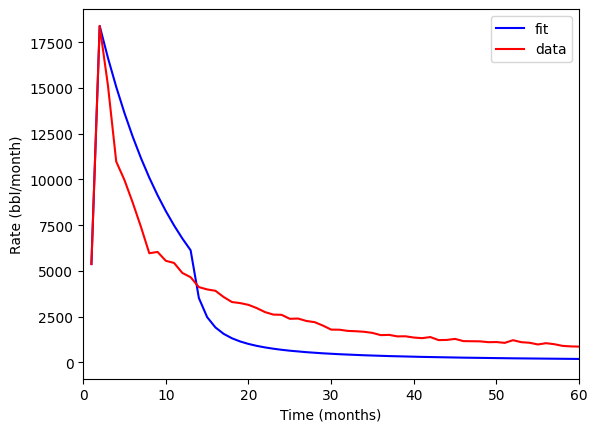

In [8]:
plt.plot((time_), (q_pred), 'b-', label='fit')
plt.plot((time_), (rate_), 'r-', label='data')
plt.xlim(0, 60)
plt.legend()
plt.xlabel('Time (months)')
plt.ylabel('Rate (bbl/month)')
plt.show()

In [9]:
def error_eval_hubber_loss(params,t0_idx,q0,qpeak,texp_idx, time, q_in):
    alpha,b,di, delta = params
    print(params)
    q_pred = multi_segment2(time,t0_idx,q0, qpeak, texp_idx,alpha,b,di)
    print("lengths", len(q_in), len(q_pred))
    # print(q_in, q_pred)
    huber_mse = 0.5*(q_in-q_pred)**2
    huber_mae = delta * (np.abs(q_in - q_pred) - 0.5 * delta)
    # print(huber_mae)
    # print("q_in", q_in)
    # print("q_pred", q_pred)
    hubber_loss =  np.where(np.abs(q_in - q_pred) <= delta, huber_mse, huber_mae)
    # print(f"hubber loss : {hubber_loss}")
    print("hubber_loss", np.sum(hubber_loss))
    # print(value)
    return np.sum(hubber_loss)

In [18]:
bounds = [ (0, 1), (0.1, 1.2), (0, None)] #(0, 10),,
t0_idx = np.argmax(rate_)
qmax = rate_.max()
q0 = rate_[0]
bounds_hubber_loss = [ (0, 1), (0.1, 1.2), (0, None), (0, 10)]
iguess_hubber_loss = [0.1, 1.02, 0.75, 1]
texp_idx_arr = np.arange(0, 12, 1)
result_list = []
for i,j in enumerate(texp_idx_arr):
    # print(i,j)
    texp_idx = j
    result_list.append(minimize(error_eval, iguess, args=(t0_idx,q0,qmax,texp_idx , time_, rate_), bounds=bounds, method='L-BFGS-B'))

texp_if 0
thyp_if 599
5371.705882352941 13031.970588235294 [0]
last of q_linear [5371.70588235]
first of expo 18403.676470588234
error 2873993791.0494103
texp_if 0
thyp_if 599
5371.705882352941 13031.970588235294 [0]
last of q_linear [5371.70588235]
first of expo 18403.676470588234
error 2873993791.0494103
texp_if 0
thyp_if 599
5371.705882352941 13031.970588235294 [0]
last of q_linear [5371.70588235]
first of expo 18403.676470588234
error 2873993658.30336
texp_if 0
thyp_if 599
5371.705882352941 13031.970588235294 [0]
last of q_linear [5371.70588235]
first of expo 18403.676470588234
error 2873993871.5012655
texp_if 0
thyp_if 599
5371.705882352941 13031.970588235294 [0]
last of q_linear [5371.70588235]
first of expo 18403.676470588234
error 17309125803645.496
texp_if 0
thyp_if 599
5371.705882352941 13031.970588235294 [0]
last of q_linear [5371.70588235]
first of expo 18403.676470588234
error 17309125803645.496
texp_if 0
thyp_if 599
5371.705882352941 13031.970588235294 [0]
last of q_linea

In [19]:
fun_val = []
for i,j in enumerate(result_list):
    fun_val.append(result_list[i].fun)

opt_idx = np.argmin(fun_val)

In [20]:
fun_val

[9.235821968904609e-05,
 9.235821968904609e-05,
 9.502182262243938e-07,
 1.0754913441870771e-05,
 2.031296302276342e-06,
 1.3931711412843585e-05,
 7.29233626762258e-06,
 2.0098210626170842e-05,
 2.685476926237604e-05,
 2.834057267268202e-05,
 2.51929711821058e-05,
 3.251037985438119e-05]

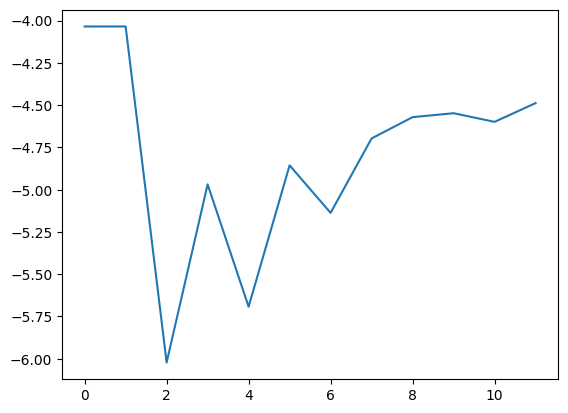

In [21]:
plt.plot(np.log10(fun_val))

In [22]:
result_list[0]

      fun: 9.235821968904609e-05
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([   0.        ,  492.52615132, -797.27352941])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 136
      nit: 13
     njev: 34
   status: 0
  success: True
        x: array([0.1       , 0.87428468, 0.27291742])

In [23]:
alpha,b,di = result_list[opt_idx].x # t0_idx,q0,m,texp_idx,alpha,b,di

In [24]:
#qout= multi_segment2(time_, t0_idx, q0,m,opt_idx+1, alpha,b,di)
qout = multi_segment2(time_, t0_idx, q0,qmax,opt_idx+1, alpha,b,di)

texp_else 2
thyp_else 597
5371.705882352941 13031.970588235294 [0]
last of q_linear [5371.70588235]
first of expo [18403.67647059 18068.1442848 ]
final_els 600


In [25]:
qout[:20]

array([ 5371.70588235, 18403.67647059, 18068.1442848 , 17738.72945539,
       12443.90374805,  9613.86444291,  7847.78984377,  6638.58459119,
        5757.71059751,  5086.85455195,  4558.56257413,  4131.5343148 ,
        3779.0528792 ,  3483.06208567,  3230.9155758 ,  3013.48917615,
        2824.03275851,  2657.4441294 ,  2509.79430415,  2378.0081046 ])

In [ ]:
eur12_diff = (qout[0:11].sum()-rate_[0:11].sum())*100/rate_[0:11].sum()
eur_diff = (qout.sum()-rate_.sum())*100/rate_.sum()
print('eur12_diff',eur12_diff)
print('eur_diff',eur_diff)

eur12_diff 1.7319897787749288
eur_diff -7.651776388398189


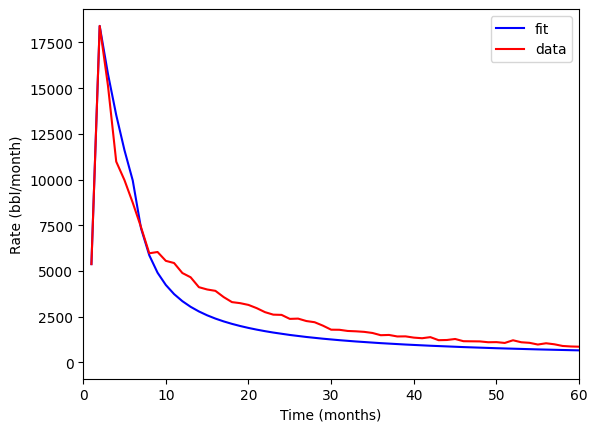

In [ ]:


plt.plot((time_), (qout), 'b-', label='fit')
plt.plot((time_), (rate_), 'r-', label='data')
plt.xlim(0, 60)
plt.legend()
plt.xlabel('Time (months)')
plt.ylabel('Rate (bbl/month)')
plt.show()

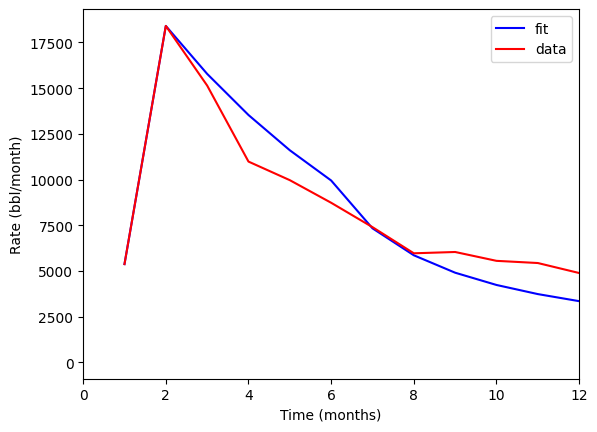

In [ ]:
plt.plot((time_), (qout), 'b-', label='fit')
plt.plot((time_), (rate_), 'r-', label='data')
plt.xlim(0, 12)
plt.legend()
plt.xlabel('Time (months)')
plt.ylabel('Rate (bbl/month)')
plt.show()

In [ ]:
import scipy.optimize as opt


error = error_eval(rate_,qout_f)

In [ ]:
error

113593714.518858